# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the 
# number of rows and columns, print the first few rows).

print(azdias.shape)
azdias.describe()

(891221, 85)


AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...          PLZ8_ANTG1  \
count          891221.000000     891221.000000      ...       774706.000000   
mean                2.874167          3.075121      ...            2.253330   
std                 1.486731          1.353248      ...            0.972008   
min                 1.000000          1.000000      ...            0.000000   
25%                 2.000000          2.000000      ...            1.000000   
50%                 3.000000          3.000000      ...            2.000000   
75%                 4.000000          4.000000      ...            3.000000   
max                 5.000000          5.000000      ...            4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  774706.000000  774706.000000  774706.000000  774706.000000   
mean        2.801858       1.595426       0.699166       1.943913   
std         0.920309       0.986736       0.727137       1.459654   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       2.000000       1.000000       1.000000   
75%         3.000000       2.000000       1.000000       3.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  774706.000000  774706.000000  794005.000000  794005.000000   
mean        3.612821       3.381087       3.167854       5.293002   
std         0.973967       1.111598       1.002376       2.303739   
min         1.000000       1.000000       1.000000       0.000000   
25%         3.000000       3.000000       3.000000       4.000000   
50%         4.000000       3.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       9.000000       9.000000   

           RELAT_AB  
count  794005.00000  
mean        3.07222  
std         1.36298  
min         1.00000  
25%         2.00000  
50%         3.00000  
75%         4.00000  
max         9.00000  

[8 rows x 81 columns]

In [4]:
azdias.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [5]:
print(type(feat_info))
print(feat_info.shape)
print(feat_info.shape[0])
feat_info.describe()

<class 'pandas.core.frame.DataFrame'>
(85, 4)
85


attribute information_level     type missing_or_unknown
count                 85                85       85                 85
unique                85                 9        5                  9
top     FINANZ_VORSORGER            person  ordinal               [-1]
freq                   1                43       49                 26

In [6]:
feat_info.head(15)

attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
print(feat_info)

                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

In [8]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html

# Build dictionary with column names as the key and value to replace as the value

n_features = feat_info.shape[0]
repdict = {}

for feat in range(n_features):
    
    attribute_name = feat_info.iloc[feat]['attribute']
    attribute_missing_values = feat_info.iloc[feat]['missing_or_unknown']
    
    print("missing or unknown encodings for feature {} (index {}): {}".format(
        attribute_name, feat, attribute_missing_values))
    
    # https://stackoverflow.com/questions/45758646/pandas-convert-string-into-list-of-strings
    missing_values_list = attribute_missing_values[1:-1].split(',')

    # https://www.geeksforgeeks.org/python-converting-all-strings-in-list-to-integers/
    # Disabled because this is problematic for empty list
    #missing_values_ints = [int(x) for x in missing_values_list]
    
    subdict = {}
    
    #print(missing_values_list)
    #print(type(missing_values_list[0]))
        
    for v in missing_values_list:
        # https://stackoverflow.com/questions/9573244/how-to-check-if-the-string-is-empty
        if v:
            try:
                subdict[int(v)] = np.nan
            except:
                subdict[v] = np.nan
    
    #print(subdict)
    
    # https://stackoverflow.com/questions/23177439/python-checking-if-a-dictionary-is-empty-doesnt-seem-to-work
    if bool(subdict):
        repdict[attribute_name] = subdict

print(repdict)

missing or unknown encodings for feature AGER_TYP (index 0): [-1,0]
missing or unknown encodings for feature ALTERSKATEGORIE_GROB (index 1): [-1,0,9]
missing or unknown encodings for feature ANREDE_KZ (index 2): [-1,0]
missing or unknown encodings for feature CJT_GESAMTTYP (index 3): [0]
missing or unknown encodings for feature FINANZ_MINIMALIST (index 4): [-1]
missing or unknown encodings for feature FINANZ_SPARER (index 5): [-1]
missing or unknown encodings for feature FINANZ_VORSORGER (index 6): [-1]
missing or unknown encodings for feature FINANZ_ANLEGER (index 7): [-1]
missing or unknown encodings for feature FINANZ_UNAUFFAELLIGER (index 8): [-1]
missing or unknown encodings for feature FINANZ_HAUSBAUER (index 9): [-1]
missing or unknown encodings for feature FINANZTYP (index 10): [-1]
missing or unknown encodings for feature GEBURTSJAHR (index 11): [0]
missing or unknown encodings for feature GFK_URLAUBERTYP (index 12): []
missing or unknown encodings for feature GREEN_AVANTGARDE

In [9]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html
azdias_cleaned = azdias.replace(to_replace=repdict)

In [10]:
print(azdias_cleaned.shape)
azdias_cleaned.describe()

(891221, 85)


AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  205378.000000         888340.000000  891221.000000  886367.000000   
mean        1.743410              2.757217       1.522098       3.632838   
std         0.674312              1.009951       0.499512       1.595021   
min         1.000000              1.000000       1.000000       1.000000   
25%         1.000000              2.000000       1.000000       2.000000   
50%         2.000000              3.000000       2.000000       4.000000   
75%         2.000000              4.000000       2.000000       5.000000   
max         3.000000              4.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...           PLZ8_ANTG1  \
count          891221.000000     891221.000000      ...        774706.000000   
mean                2.874167          3.075121      ...             2.253330   
std                 1.486731          1.353248      ...             0.972008   
min                 1.000000          1.000000      ...             0.000000   
25%                 2.000000          2.000000      ...             1.000000   
50%                 3.000000          3.000000      ...             2.000000   
75%                 4.000000          4.000000      ...             3.000000   
max                 5.000000          5.000000      ...             4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  774706.000000  774706.000000  774706.000000  774706.000000   
mean        2.801858       1.595426       0.699166       1.943913   
std         0.920309       0.986736       0.727137       1.459654   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       2.000000       1.000000       1.000000   
75%         3.000000       2.000000       1.000000       3.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  774706.000000  774706.000000  793846.000000  793947.000000   
mean        3.612821       3.381087       3.166686       5.293389   
std         0.973967       1.111598       0.999072       2.303379   
min         1.000000       1.000000       1.000000       1.000000   
25%         3.000000       3.000000       3.000000       4.000000   
50%         4.000000       3.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       5.000000       9.000000   

            RELAT_AB  
count  793846.000000  
mean        3.071033  
std         1.360532  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         4.000000  
max         5.000000  

[8 rows x 81 columns]

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

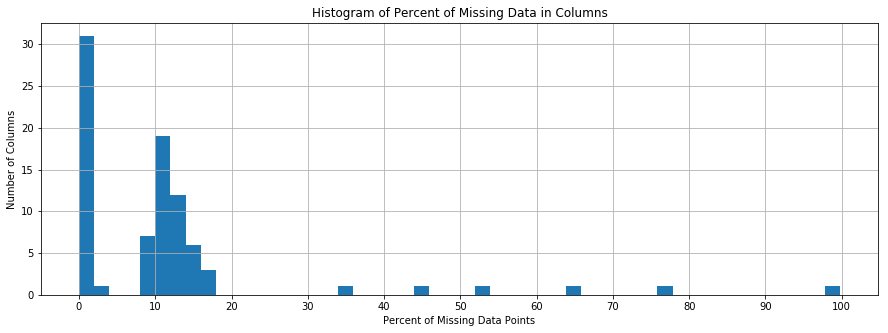

In [11]:
# Perform an assessment of how much missing data there is in each column of the dataset.

counts = azdias_cleaned.count()
irange = range(n_features)
n_missing_list = []
pct_missing_list = []

for i in irange:
    
    n_missing = azdias_cleaned.shape[0] - counts.iloc[i]
    pct_missing = (n_missing / azdias_cleaned.shape[0])*100.0
    
    #print("There were {} of {} items in column {} ({} missing) ({:.2f}% of data)".format(
    #    counts.iloc[i], azdias_cleaned.shape[0], i, n_missing, pct_missing))
    
    n_missing_list.append(n_missing)
    pct_missing_list.append(pct_missing)
    
pcts_missing = pd.Series(pct_missing_list, index=counts.index)
    
fig = plt.figure(figsize=(15,5))
ax = fig.gca()
plt.hist(pct_missing_list, bins=50) # 2% increments
plt.grid()
plt.xticks(np.arange(0, 110, step=10))
plt.title('Histogram of Percent of Missing Data in Columns')
plt.xlabel('Percent of Missing Data Points')
plt.ylabel('Number of Columns');

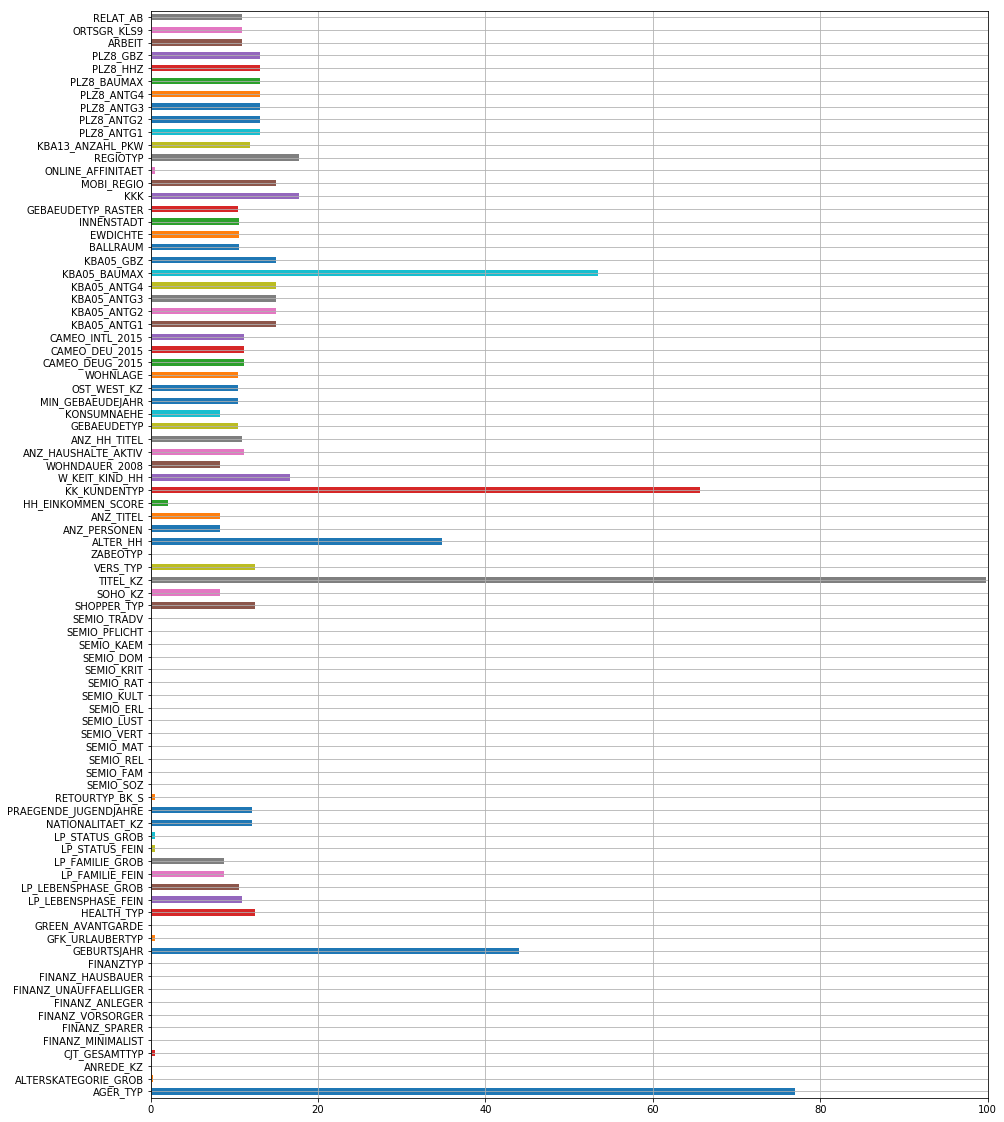

In [12]:
# Investigate patterns in the amount of missing data in each column.

fig = plt.figure(figsize=(15,20))
ax = fig.gca()
pcts_missing.plot.barh(ax=ax);
plt.grid()
plt.xlim(0, 100);

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

print("Found {} of {} columns with at least 10% missing data".format(
    pcts_missing[pcts_missing >= 10.0].index.size, n_features))

print("Found {} of {} columns with at least 20% missing data".format(
    pcts_missing[pcts_missing >= 20.0].index.size, n_features))

drop_index = pcts_missing[pcts_missing >= 20.0].index
drop_list = drop_index.tolist
print(drop_index)
print(drop_list)
print(type(azdias_cleaned))

# azdias_cleaned.drop(columns=drop_list) # TypeError: unhashable type: 'Index'
drop_columns=['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

# NB: It won't work to run this cell twice (2nd time generates error) without errors='ignore'
azdias_cleaned.drop(columns=drop_columns, inplace=True, errors='ignore')

Found 46 of 85 columns with at least 10% missing data
Found 6 of 85 columns with at least 20% missing data
Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')
<bound method IndexOpsMixin.tolist of Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')>
<class 'pandas.core.frame.DataFrame'>


#### Discussion 1.1.2: Assess Missing Data in Each Column

The missing column data generally followed in three categories, as indicated in the histogram above:
1. no more than 4% missing data (39 columns)
2. 8% to 18% missing data (40 columns), and
3. more than 34% missing data (6 columns).

Many of the columns have a similar number of missing data points according to prefix (e.g., PLZ8, CAMEO).

Based on the instructions indicating a "few columns that are outliers in terms of the proportion of values that are missing", I chose to eliminate category 3 above, which has the following six columns: 
1. 'AGER_TYP' ("Best-ager typology")
2. 'GEBURTSJAHR' ("Year of birth")
3. 'TITEL_KZ' ("Academic title flag")
4. 'ALTER_HH' ("Birthdate of head of household")
5. 'KK_KUNDENTYP' ("Consumer pattern over past 12 months")
6. 'KBA05_BAUMAX' ("Most common building type within the microcell")

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# https://thispointer.com/python-pandas-count-number-of-nan-or-missing-values-in-dataframe-also-row-column-wise/
print(azdias.isnull().sum().sum())
print(azdias.isnull().sum())
print(azdias_cleaned.isnull().sum().sum())
azdias_cleaned.head(10)

4896838
AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  


ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                   2.0          1            2.0                  3   
1                   1.0          2            5.0                  1   
2                   3.0          2            3.0                  1   
3                   4.0          2            2.0                  4   
4                   3.0          1            5.0                  4   
5                   1.0          2            2.0                  3   
6                   2.0          2            5.0                  1   
7                   1.0          1            3.0                  3   
8                   3.0          1            3.0                  4   
9                   3.0          2            4.0                  2   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0              4                 3               5                      5   
1              5                 2               5                      4   
2              4                 1               2                      3   
3              2                 5               2                      1   
4              3                 4               1                      3   
5              1                 5               2                      2   
6              5                 1               5                      4   
7              3                 4               1                      3   
8              4                 2               4                      2   
9              4                 2               3                      5   

   FINANZ_HAUSBAUER  FINANZTYP    ...     PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  \
0                 3          4    ...            NaN         NaN         NaN   
1                 5          1    ...            2.0         3.0         2.0   
2                 5          1    ...            3.0         3.0         1.0   
3                 2          6    ...            2.0         2.0         2.0   
4                 2          5    ...            2.0         4.0         2.0   
5                 5          2    ...            2.0         3.0         1.0   
6                 3          4    ...            3.0         3.0         1.0   
7                 2          5    ...            3.0         3.0         1.0   
8                 2          6    ...            2.0         3.0         2.0   
9                 4          1    ...            2.0         3.0         2.0   

   PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  RELAT_AB  
0         NaN          NaN       NaN       NaN     NaN          NaN       NaN  
1         1.0          1.0       5.0       4.0     3.0          5.0       4.0  
2         0.0          1.0       4.0       4.0     3.0          5.0       2.0  
3         0.0          1.0       3.0       4.0     2.0          3.0       3.0  
4         1.0          2.0       3.0       3.0     4.0          6.0       5.0  
5         1.0          1.0       5.0       5.0     2.0          3.0       3.0  
6         0.0          1.0       5.0       5.0     4.0          6.0       3.0  
7         0.0          1.0       4.0       4.0     2.0          5.0       2.0  
8         1.0          1.0       3.0       3.0     2.0          4.0       3.0  
9         1.0          1.0       3.0       3.0     2.0          3.0       1.0  

[10 rows x 79 columns]

In [15]:
# How much data is missing in each row of the dataset?

# (too slow! -->) https://thispointer.com/python-pandas-count-number-of-nan-or-missing-values-in-dataframe-also-row-column-wise/
# https://datascience.stackexchange.com/questions/12645/how-to-count-the-number-of-missing-values-in-each-row-in-pandas-dataframe
n_missing_rows = azdias_cleaned.isnull().sum(axis=1)

print("Of the {} rows, there are between {} and {} missing values in the {} columns.".format(
    len(azdias_cleaned.index), min(n_missing_rows), max(n_missing_rows), azdias_cleaned.shape[1]))

Of the 891221 rows, there are between 0 and 49 missing values in the 79 columns.


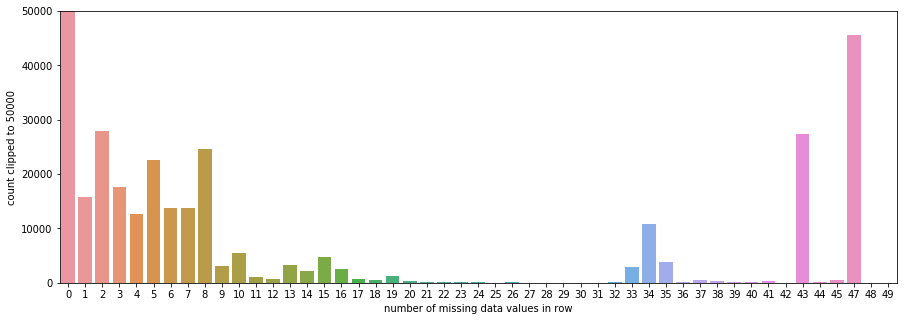

In [16]:
# Write code to divide the data into two subsets based on the number of missing values in each row.

fig = plt.figure(figsize=(15,5))
ax = fig.gca()
sns.countplot(x=n_missing_rows);
plt.ylim(0, 50000)
plt.ylabel('count clipped to 50000');
plt.xlabel('number of missing data values in row');

In [17]:
# The instructions are to "Divide the data into two subsets: one for data points that are above some threshold for 
# missing values, and a second subset for points below that threshold." Based on the histogram above, there are 
# several reasonable options for such a threshold. 

# Somewhat arbitrarily, I will choose a threshold of 8 missing data values, above which I will consider in the 
# second subset ("too much missing data"). This seems to capture a significant majority of the data points, and 
# avoids rows with large numbers of missing data. I'll coin these a  "robust" data subset and a "meager" data subset.

n_missing_data_threshold = 8
robust_mask = (n_missing_rows <= n_missing_data_threshold)
meager_mask = (n_missing_rows > n_missing_data_threshold)

azdias_robust = azdias_cleaned[robust_mask]
azdias_meager = azdias_cleaned[meager_mask]

print(azdias_robust.shape)
print(azdias_meager.shape)
print(azdias_cleaned.shape)
print(azdias_robust.shape[0] + azdias_meager.shape[0])

(771701, 79)
(119520, 79)
(891221, 79)
891221


In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# I take this to mean we want to have some histograms to compare between the two subsets, and choose these histograms 
# to be of variables at least after culling the 6 columns above, and perhaps further per a more strict interpretation
# of the subjective part of "columns that are not missing data (or are missing very little data)"

dat = pcts_missing[pcts_missing < 0.01].index
print(list(dat))
print(dat.size)
print(max(pcts_missing[dat]))

['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP']
24
0.0


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


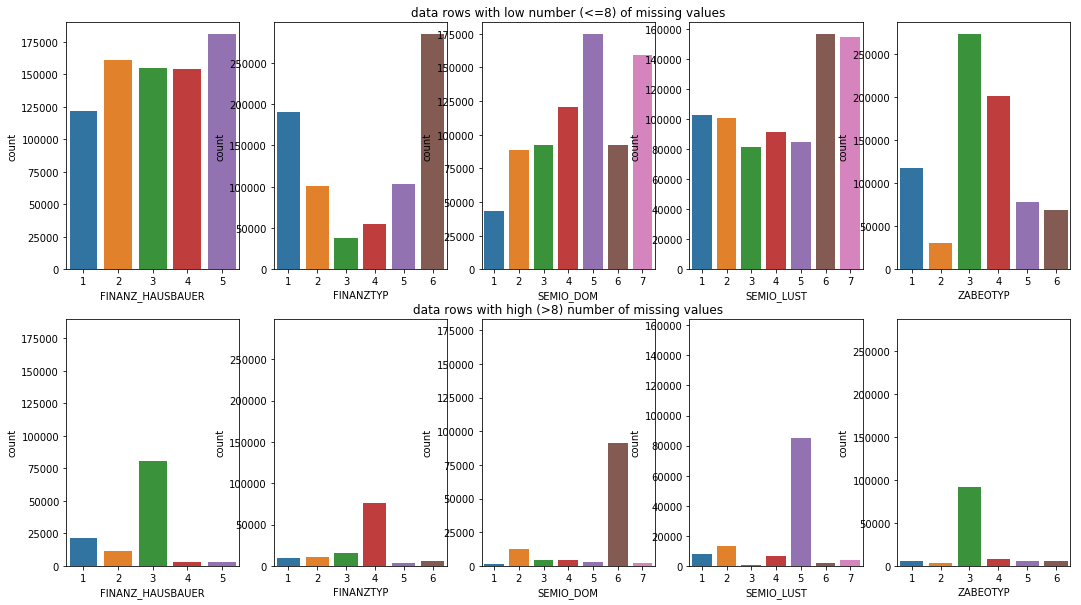

In [19]:
# Select at least five of these columns and compare the distribution of values.
# You can use seaborn's countplot() function to create a bar chart of code frequencies and matplotlib's 
# subplot() function to put bar charts for the two subplots side by side.
# To reduce repeated code, you might want to write a function that can perform this comparison, 
# taking as one of its arguments a column to be compared.

column_name = ['FINANZ_HAUSBAUER', 'FINANZTYP', 'SEMIO_DOM', 'SEMIO_LUST', 'ZABEOTYP']
fig = plt.figure(figsize=(18,10))
hf, ha = fig.subplots(2,len(column_name))

for i, name in enumerate(column_name,1):
    x_meager = azdias_meager[name]
    x_robust = azdias_robust[name]
    #print(x_meager.shape)
    #print(x_robust.shape)

    plt.subplot(2, len(column_name), i)
    sns.countplot(np.squeeze(x_robust))
    ylim = plt.ylim()
    plt.subplot(2, len(column_name), len(column_name) + i)
    sns.countplot(np.squeeze(x_meager))
    plt.ylim(ylim)

plt.subplot(2, len(column_name), 3)
plt.title('data rows with low number (<=8) of missing values')
plt.subplot(2, len(column_name), 8)
plt.title('data rows with high (>8) number of missing values');

#### Discussion 1.1.3: Assess Missing Data in Each Row

I subjectively chose the columns ['FINANZ_HAUSBAUER', 'FINANZTYP', 'SEMIO_DOM', 'SEMIO_LUST', 'ZABEOTYP'] for comparison of countplot bar charts, since these are among the columns had no missing data in them.

1. FINANZ_HAUSBAUER - Financial typology, for home ownership (1: very high, 3: average, 5: very low)
2. FINANZTYP - Most descriptive financial type for individual (1: low, 4: be prepared, 6: inconspicuous)
3. SEMIO_DOM - Personality typology, for DOM: dominant-minded (1: highest affinity, 6: very low affinity)
4. SEMIO_LUST - Personality typology, for LUST: sensual-minded (1: highest affinity, 5: low affinity, 7: lowest)
5. ZABEOTYP - Energy consumption typology (1: green, 3: fair supplied, 6: indifferent)

I have set the y-axis limits to be the same for each pair of bar plots, for easier comparison. It is apparent from an inspection of the figure above that the distribution of data for these categories is not similar between the sparse data rows (each with >8 missing values) and robust data rows (each with <=8 missing values). The sparse data seems to be dominated by a particular value in each of these columns:

1. FINANZ_HAUSBAUER - Sparse data is mostly "average" home ownership financial typology
2. FINANZTYP - Sparse data is mostly "be prepared" in most descriptive financial type
3. SEMIO_DOM - Sparse data is mostly "very low affinity" for dominant-minded personality typology
4. SEMIO_LUST - Sparse data is mostly "low affinity" for sensual-minded personality typology
5. ZABEOTYP - Sparse data is mostly "fair supplied" for energy consumption typology

Since the data distributions are qualitatively different between the sparse and robust data sets, we can proceed comfortably with the previously-given direction to drop the sparse data in the rest of the investigation.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
# How many features are there of each data type?

n_numeric = feat_info[feat_info['type'] == 'numeric'].index.size
n_interval = feat_info[feat_info['type'] == 'interval'].index.size
n_ordinal = feat_info[feat_info['type'] == 'ordinal'].index.size
n_categorical = feat_info[feat_info['type'] == 'categorical'].index.size
n_mixed = feat_info[feat_info['type'] == 'mixed'].index.size
n_total = n_numeric + n_interval + n_ordinal + n_categorical + n_mixed

print("There are {} numeric-valued attributes".format(n_numeric))
print("There are {} interval-valued attributes".format(n_interval))
print("There are {} ordinal-valued attributes".format(n_ordinal))
print("There are {} categorical-valued attributes".format(n_categorical))
print("There are {} mixed-valued attributes".format(n_mixed))
print("That makes a total of {} attributes".format(n_total))

There are 7 numeric-valued attributes
There are 1 interval-valued attributes
There are 49 ordinal-valued attributes
There are 21 categorical-valued attributes
There are 7 mixed-valued attributes
That makes a total of 85 attributes


In [21]:
feat_info[feat_info['type'] == 'mixed']

attribute information_level   type missing_or_unknown
15    LP_LEBENSPHASE_FEIN            person  mixed                [0]
16    LP_LEBENSPHASE_GROB            person  mixed                [0]
22  PRAEGENDE_JUGENDJAHRE            person  mixed             [-1,0]
56               WOHNLAGE          building  mixed               [-1]
59        CAMEO_INTL_2015     microcell_rr4  mixed            [-1,XX]
64           KBA05_BAUMAX     microcell_rr3  mixed             [-1,0]
79            PLZ8_BAUMAX    macrocell_plz8  mixed             [-1,0]

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

repdict_2 = {}
drop_columns_2 = []
re_encode_columns = []

for attr in feat_info[feat_info['type'] == 'categorical'].index:
    attr_name = feat_info.iloc[attr]['attribute']
    if attr_name in drop_columns:
        print("(x) We already dropped column {} from the DataFrame".format(attr_name))
    else:
        try:
            slist = sorted(azdias_robust[attr_name].unique().tolist())
        except TypeError:
            slist = azdias_robust[attr_name].unique().tolist()
            
        if (len(slist) == 2) and (all(isinstance(x, (int, float)) for x in slist)):
            print("(/) {} is a two-level numeric categorical with values (AOK) {}".format(attr_name, slist))
        elif (len(slist) == 2) and (all(isinstance(x, string)) for x in slist):
            print("(/) {} has two-level non-numeric values (will replace) {}".format(attr_name, slist))
            repdict_2[attr_name] = {slist[0]: 0, slist[1]: 1}
        elif np.nan in slist:
            print("(x) {} has a nan in the list of unique values (will drop) {}".format(attr_name, slist))
            drop_columns_2.append(attr_name)
        elif azdias_robust[attr_name].isnull().values.any():
            print("(x) {} contains null values (will drop) {}".format(attr_name, slist))
            drop_columns_2.append(attr_name)
        else:
            print("(/) {} is multi-level with unique values (will OneHotEncode) {}".format(attr_name, slist))
            re_encode_columns.append(attr_name)

(x) We already dropped column AGER_TYP from the DataFrame
(/) ANREDE_KZ is a two-level numeric categorical with values (AOK) [1, 2]
(/) CJT_GESAMTTYP is multi-level with unique values (will OneHotEncode) [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
(/) FINANZTYP is multi-level with unique values (will OneHotEncode) [1, 2, 3, 4, 5, 6]
(/) GFK_URLAUBERTYP is multi-level with unique values (will OneHotEncode) [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
(/) GREEN_AVANTGARDE is a two-level numeric categorical with values (AOK) [0, 1]
(x) LP_FAMILIE_FEIN contains null values (will drop) [1.0, 5.0, nan, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
(x) LP_FAMILIE_GROB contains null values (will drop) [1.0, 3.0, nan, 2.0, 4.0, 5.0]
(/) LP_STATUS_FEIN is multi-level with unique values (will OneHotEncode) [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
(/) LP_STATUS_GROB is multi-level with unique values (will OneHotEncode) [1.0, 2.0, 3.0, 4.0, 5.0]
(x) NATIONALITAET_KZ contains null 

In [23]:
# Re-encode categorical variable(s) to be kept in the analysis.

# NB: It won't work to run this cell twice (2nd time generates error)
print("Dropping columns {}".format(drop_columns_2))
azdias_temp = azdias_robust.drop(columns=drop_columns_2)

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html
print("Replacing values {}".format(repdict_2))
azdias_temp.replace(to_replace=repdict_2, inplace=True)

print("Performing One-Hot Encoding on {}".format(re_encode_columns))

azdias_encoded = pd.get_dummies(azdias_temp, columns=re_encode_columns)

print(azdias_robust.shape)
print(azdias_temp.shape)
print(len(re_encode_columns))
print(azdias_temp[re_encode_columns].shape)
print(azdias_encoded.shape)
print(list(azdias_encoded.columns))

Dropping columns ['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Replacing values {'OST_WEST_KZ': {'O': 0, 'W': 1}}
Performing One-Hot Encoding on ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'ZABEOTYP', 'GEBAEUDETYP']
(771701, 79)
(771701, 72)
7
(771701, 7)
(771701, 117)
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',

#### Discussion 1.2.1: Re-Encode Categorical Features

Of the twenty-one (21) categorical features, 
* I had already dropped three (3) early in this process (due to excessive missing data in columns);
* three (3) (ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ) were OK as-is, being binary-valued and numerical;
* I converted one (1) (OST_WEST_KZ) from text values to numerical values;
* I dropped seven (7) due to the presence of null or nan values (out of convenience rather than necessity); and
* I kept and coverted seven (7) with one-hot encoding (expanding into 52 columns).

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [24]:
for attr in feat_info[feat_info['type'] == 'mixed'].index:
    attr_name = feat_info.iloc[attr]['attribute']
    if attr_name in drop_columns:
        print("(x) We already dropped column {} from the DataFrame".format(attr_name))
    else:
        try:
            slist = sorted(azdias_robust[attr_name].unique().tolist())
        except TypeError:
            slist = azdias_robust[attr_name].unique().tolist()
        
        print("(-) {} is a mixed column with unique values {}".format(attr_name,slist))

(-) LP_LEBENSPHASE_FEIN is a mixed column with unique values [1.0, 3.0, 21.0, nan, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0]
(-) LP_LEBENSPHASE_GROB is a mixed column with unique values [1.0, 6.0, nan, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
(-) PRAEGENDE_JUGENDJAHRE is a mixed column with unique values [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, nan]
(-) WOHNLAGE is a mixed column with unique values [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0]
(-) CAMEO_INTL_2015 is a mixed column with unique values ['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41', '34', '55', '25', nan, '23', '31', '52', '35', '45', '44', '32']
(x) We already dropped column KBA05_BAUMAX from the DataFrame
(-) PLZ8_BAUMAX is a mixed column with unique values [1.0, 2.0, nan, 3.0, 4.0, 5

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# While there aren't enough levels to disentangle east from west, 
# you should create two new variables to capture the other two dimensions: 
# an interval-type variable for decade, and a binary variable for movement.

vals_mainstream = [1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0]
vals_avantgarde = [2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0]
vals_40s = [1.0, 2.0]
vals_50s = [3.0, 4.0]
vals_60s = [5.0, 6.0]
vals_70s = [8.0, 9.0]
vals_80s = [10.0, 11.0, 12.0, 13.0]
vals_90s = [14.0, 15.0]

print(azdias_encoded.shape)

azdias_encoded['PRAEGENDE'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE']
azdias_encoded['PRAEGENDE'].replace(to_replace=vals_mainstream, value=0, inplace=True)
azdias_encoded['PRAEGENDE'].replace(to_replace=vals_avantgarde, value=1, inplace=True)

# NB: the order of replacement matters
azdias_encoded['JUGENDJAHRE'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].fillna(0)
azdias_encoded['JUGENDJAHRE'].replace(to_replace=vals_70s, value=7, inplace=True)
azdias_encoded['JUGENDJAHRE'].replace(to_replace=vals_60s, value=6, inplace=True)
azdias_encoded['JUGENDJAHRE'].replace(to_replace=vals_50s, value=5, inplace=True)
azdias_encoded['JUGENDJAHRE'].replace(to_replace=vals_80s, value=8, inplace=True)
azdias_encoded['JUGENDJAHRE'].replace(to_replace=vals_90s, value=9, inplace=True)
azdias_encoded['JUGENDJAHRE'].replace(to_replace=vals_40s, value=4, inplace=True)
azdias_encoded['JUGENDJAHRE'].replace(to_replace=0, value=np.nan, inplace=True)

# I abandoned this alternate approach that would one-hot encode each of the values
# http://www.datasciencemadesimple.com/logical-and-operation-of-column-in-pandas-python-2/
# https://markhneedham.com/blog/2015/02/16/pythonpandas-column-value-in-list-valueerror-the-truth-value-of-a-series-is-ambiguous/
# https://stackoverflow.com/questions/17383094/how-can-i-map-true-false-to-1-0-in-a-pandas-dataframe
#azdias_encoded['PRAEGENDE_Mainstream'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].isin(inds_mainstream).astype(int)
#azdias_encoded['PRAEGENDE_Avantgarde'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].isin(inds_avantgarde).astype(int)
#azdias_encoded['JUGENDJAHRE_40s'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].isin(inds_40s).astype(int)
#azdias_encoded['JUGENDJAHRE_50s'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].isin(inds_50s).astype(int)
#azdias_encoded['JUGENDJAHRE_60s'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].isin(inds_60s).astype(int)
#azdias_encoded['JUGENDJAHRE_70s'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].isin(inds_70s).astype(int)
#azdias_encoded['JUGENDJAHRE_80s'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].isin(inds_80s).astype(int)
#azdias_encoded['JUGENDJAHRE_90s'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].isin(inds_90s).astype(int)

print(azdias_encoded.shape)

(771701, 117)
(771701, 119)


[0.0, 1.0, nan]
[9.0, 7.0, 5.0, 8.0, 6.0, nan, 4.0]
[14.0, 15.0, 8.0, 3.0, 10.0, 11.0, 5.0, 9.0, 6.0, 4.0, nan, 2.0, 1.0, 12.0, 13.0, 7.0]


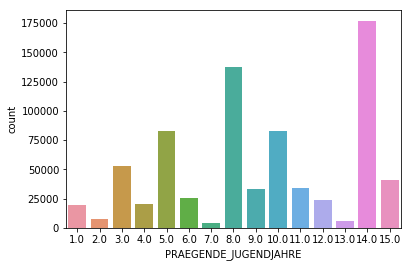

In [26]:
print(azdias_encoded['PRAEGENDE'].unique().tolist())
print(azdias_encoded['JUGENDJAHRE'].unique().tolist())
print(azdias_encoded['PRAEGENDE_JUGENDJAHRE'].unique().tolist())

sns.countplot(np.squeeze(azdias_encoded['PRAEGENDE_JUGENDJAHRE']));

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables 
# (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

tmp = azdias_encoded['CAMEO_INTL_2015'].fillna(value=0).astype(int)

azdias_encoded['CAMEO_INTL_2015_Family'] = tmp.mod(10)
azdias_encoded['CAMEO_INTL_2015_Affluence'] = tmp.floordiv(10)

print("Example: CAMEO_INTL_2015 value {} is Affluence Class {} (lower is more) and Family Type {}".format(
    tmp.iloc[0], tmp.floordiv(10).iloc[0], tmp.mod(10).iloc[0]))

Example: CAMEO_INTL_2015 value 51 is Affluence Class 5 (lower is more) and Family Type 1


In [28]:
# Now we can drop the mixed columns, since we have added engineered variables for "PRAEGENDE_JUGENDJAHRE" and 
# "CAMEO_INTL_2015". I will also drop the remaining mixed attributes for the sake of time efficiency.
mixed_columns = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
print(azdias_encoded.shape)
print("Dropping columns {}".format(mixed_columns))
azdias_encoded.drop(columns=mixed_columns, inplace=True, errors='ignore')
print(azdias_encoded.shape)

(771701, 121)
Dropping columns ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']
(771701, 115)


#### Discussion 1.2.2: Engineer Mixed-Type Features

As instructed, I re-encoded "PRAEGENDE_JUGENDJAHRE" into two new engineered features: a "PRAEGENDE" (Dominating movement during youth) and "JUGENDJAHRE" (principal decade of youth). The latter I just encoded as a number rather than an interval, because I didn't see it as fundamentally different than GEBURTSJAHR (year of birth).

I also re-encoded "CAMEO_INTL_2015" as instructed, encoding the 10's place as an affluence ('CAMEO_INTL_2015_Affluence') and the 1's place as a family type ('CAMEO_INTL_2015_Family').

I dropped the remaining mixed variable types, for the sake of time efficiency, and also dropped the two above since they were successfully re-encoded.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

#### Discussion 1.2.3: Double-check

* Started with 85 columns
* Dropped 6 of them due to missing data fraction (including 3 categorical) (['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX’])
* Dropped 7 more categorical columns with missing or nan data.
* 7 multi-valued categorical columns were converted into 52 one-hot encoded features
* Added 4 columns as re-encoding of 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'
* Dropped remaining 6 mixed columns (including 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015')

=> Left with 85 - 6 - 7 - 7 + 52 + 2 + 2 - 6 = 115

I think I have my bases covered here with regards to completing feature selection.

In [29]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

print(85 - 6 - 7 - 7 + 52 + 2 + 2 - 6)

115


In [30]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [31]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html
    df_cleaned = df.replace(to_replace=repdict)
    
    # remove selected columns and rows, ...

    df_cleaned.drop(columns=drop_columns, inplace=True, errors='ignore')
    
    n_missing_rows = df_cleaned.isnull().sum(axis=1)

    print("Of the {} rows, there are between {} and {} missing values in the {} columns.".format(
        len(df_cleaned.index), min(n_missing_rows), max(n_missing_rows), df_cleaned.shape[1]))
    
    n_missing_data_threshold = 8
    robust_mask = (n_missing_rows <= n_missing_data_threshold)
    df_robust = df_cleaned[robust_mask]

    # select, re-encode, and engineer column values.

    # NB: It won't work to run this cell twice (2nd time generates error)
    print("Dropping columns {}".format(drop_columns_2))
    df_temp = df_robust.drop(columns=drop_columns_2)

    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html
    print("Replacing values {}".format(repdict_2))
    df_temp.replace(to_replace=repdict_2, inplace=True)

    print("Performing One-Hot Encoding on {}".format(re_encode_columns))

    df_encoded = pd.get_dummies(df_temp, columns=re_encode_columns)

    df_encoded['PRAEGENDE'] = df_encoded['PRAEGENDE_JUGENDJAHRE']
    df_encoded['PRAEGENDE'].replace(to_replace=vals_mainstream, value=0, inplace=True)
    df_encoded['PRAEGENDE'].replace(to_replace=vals_avantgarde, value=1, inplace=True)

    # NB: the order of replacement matters
    df_encoded['JUGENDJAHRE'] = df_encoded['PRAEGENDE_JUGENDJAHRE'].fillna(0)
    df_encoded['JUGENDJAHRE'].replace(to_replace=vals_70s, value=7, inplace=True)
    df_encoded['JUGENDJAHRE'].replace(to_replace=vals_60s, value=6, inplace=True)
    df_encoded['JUGENDJAHRE'].replace(to_replace=vals_50s, value=5, inplace=True)
    df_encoded['JUGENDJAHRE'].replace(to_replace=vals_80s, value=8, inplace=True)
    df_encoded['JUGENDJAHRE'].replace(to_replace=vals_90s, value=9, inplace=True)
    df_encoded['JUGENDJAHRE'].replace(to_replace=vals_40s, value=4, inplace=True)
    df_encoded['JUGENDJAHRE'].replace(to_replace=0, value=np.nan, inplace=True)

    df_tmp = df_encoded['CAMEO_INTL_2015'].fillna(value=0).astype(int)
    df_encoded['CAMEO_INTL_2015_Family'] = df_tmp.mod(10)
    df_encoded['CAMEO_INTL_2015_Affluence'] = df_tmp.floordiv(10)

    print("Dropping columns {}".format(mixed_columns))
    df_encoded.drop(columns=mixed_columns, inplace=True, errors='ignore')

    # Return the cleaned dataframe.
    
    return df_encoded
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [32]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.

n_missing_rows = azdias_encoded.isnull().sum(axis=1)

print("Of the {} rows, there are between {} and {} missing values in the {} columns.".format(
    len(azdias_encoded.index), min(n_missing_rows), max(n_missing_rows), azdias_encoded.shape[1]))

Of the 771701 rows, there are between 0 and 9 missing values in the 115 columns.


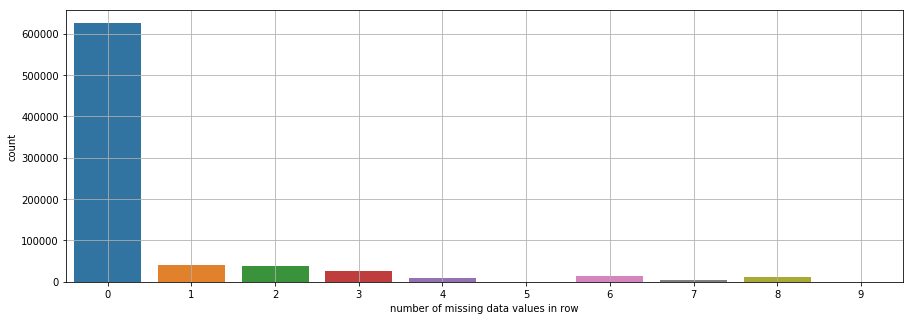

In [33]:
fig = plt.figure(figsize=(15,5))
ax = fig.gca()
sns.countplot(x=n_missing_rows);
#plt.ylim(0, 50000)
plt.ylabel('count');
plt.xlabel('number of missing data values in row');
plt.grid()

In [34]:
print(azdias_encoded.shape)

azdias_encoded.dropna(axis=0, inplace=True)

# I learned later that the customer set doesn't have any of these: 'GEBAEUDETYP_5.0'
azdias_encoded.drop(columns=['GEBAEUDETYP_5.0'], inplace=True, errors='ignore')

print(azdias_encoded.shape)

(771701, 115)
(625850, 114)


In [35]:
# Apply feature scaling to the general population demographics data.

# https://stackoverflow.com/questions/35723472/how-to-use-sklearn-fit-transform-with-pandas-and-return-dataframe-instead-of-num
scaler = StandardScaler()
scaled_features = scaler.fit_transform(azdias_encoded.values)
azdias_scaled = pd.DataFrame(scaled_features, index=azdias_encoded.index, columns=azdias_encoded.columns)

azdias_scaled.describe()

ALTERSKATEGORIE_GROB     ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count          6.258500e+05  6.258500e+05       6.258500e+05   6.258500e+05   
mean           6.662083e-17  2.024227e-16       6.834653e-18  -1.043590e-16   
std            1.000001e+00  1.000001e+00       1.000001e+00   1.000001e+00   
min           -1.746548e+00 -1.022455e+00      -1.513156e+00  -1.141246e+00   
25%           -7.722869e-01 -1.022455e+00      -7.783798e-01  -1.141246e+00   
50%            2.019741e-01  9.780377e-01      -4.360401e-02   2.201992e-01   
75%            1.176235e+00  9.780377e-01       6.911717e-01   9.009220e-01   
max            1.176235e+00  9.780377e-01       1.425948e+00   1.581645e+00   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count      6.258500e+05    6.258500e+05           6.258500e+05   
mean      -6.137563e-17    3.223186e-17           1.209802e-16   
std        1.000001e+00    1.000001e+00           1.000001e+00   
min       -1.764208e+00   -1.222534e+00          -1.138511e+00   
25%       -1.044264e+00   -1.222534e+00          -1.138511e+00   
50%        3.956248e-01    1.578665e-01          -4.097325e-01   
75%        1.115569e+00    8.480667e-01           1.047825e+00   
max        1.115569e+00    1.538267e+00           1.776604e+00   

       FINANZ_HAUSBAUER  GREEN_AVANTGARDE    HEALTH_TYP  \
count      6.258500e+05      6.258500e+05  6.258500e+05   
mean      -1.214797e-16      3.678451e-18  2.895077e-17   
std        1.000001e+00      1.000001e+00  1.000001e+00   
min       -1.588103e+00     -5.533730e-01 -1.591787e+00   
25%       -8.557766e-01     -5.533730e-01 -2.735946e-01   
50%       -1.234500e-01     -5.533730e-01 -2.735946e-01   
75%        6.088766e-01     -5.533730e-01  1.044597e+00   
max        1.341203e+00      1.807099e+00  1.044597e+00   

                 ...              GEBAEUDETYP_1.0  GEBAEUDETYP_2.0  \
count            ...                 6.258500e+05         625850.0   
mean             ...                 6.865306e-17              0.0   
std              ...                 1.000001e+00              0.0   
min              ...                -1.161410e+00              0.0   
25%              ...                -1.161410e+00              0.0   
50%              ...                 8.610226e-01              0.0   
75%              ...                 8.610226e-01              0.0   
max              ...                 8.610226e-01              0.0   

       GEBAEUDETYP_3.0  GEBAEUDETYP_4.0  GEBAEUDETYP_6.0  GEBAEUDETYP_8.0  \
count     6.258500e+05         625850.0         625850.0     6.258500e+05   
mean     -2.148034e-17              0.0              0.0    -8.496767e-17   
std       1.000001e+00              0.0              0.0     1.000001e+00   
min      -5.390942e-01              0.0              0.0    -5.008662e-01   
25%      -5.390942e-01              0.0              0.0    -5.008662e-01   
50%      -5.390942e-01              0.0              0.0    -5.008662e-01   
75%      -5.390942e-01              0.0              0.0    -5.008662e-01   
max       1.854963e+00              0.0              0.0     1.996541e+00   

          PRAEGENDE   JUGENDJAHRE  CAMEO_INTL_2015_Family  \
count  6.258500e+05  6.258500e+05            6.258500e+05   
mean   3.678451e-18  7.763348e-17           -9.604844e-18   
std    1.000001e+00  1.000001e+00            1.000001e+00   
min   -5.533730e-01 -2.289492e+00           -1.899363e+00   
25%   -5.533730e-01 -9.082453e-01           -1.236101e+00   
50%   -5.533730e-01 -2.176217e-01            9.042458e-02   
75%   -5.533730e-01  1.163625e+00            7.536873e-01   
max    1.807099e+00  1.163625e+00            1.416950e+00   

       CAMEO_INTL_2015_Affluence  
count               6.258500e+05  
mean                3.328771e-17  
std                 1.000001e+00  
min                -2.252500e+00  
25%                -8.925293e-01  
50%                 4.674411e-01  
75%                 1.147426e+00  
max          

### Discussion 2.1: Apply Feature Scaling

I dropped all rows with missing or nan data, to work through the problem set more directly, and since these rows represented a small minority of the data.

Since the `fit_transform()` method of `StandardScaler` returns a NumPy ndarray, I converted it back to a dataframe using the Pandas DataFrame constructor, as suggested in the included Stack Overflow post listed above.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [36]:
# Apply PCA to the data.

pca_all = PCA()
pca_all.fit(azdias_scaled.values)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [37]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(0, 27, 8):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

0.419987851722
0.456243519645
0.593658859337
0.695732693858
0.787113239741
0.863054127745
[  1.26270759e-01   9.53484677e-02   6.05098420e-02   4.37751672e-02
   2.75979572e-02   2.53961397e-02   2.13957299e-02   1.96937894e-02
   1.83481441e-02   1.79075238e-02   1.72470165e-02   1.57742988e-02
   1.51092537e-02   1.43409184e-02   1.40161136e-02   1.27571959e-02
   1.23636021e-02   1.22187321e-02   1.19834617e-02   1.16047469e-02
   1.08976275e-02   1.06688168e-02   1.04080422e-02   1.03184907e-02
   1.02534546e-02   1.00927266e-02   9.96553345e-03   9.94951297e-03
   9.82657159e-03   9.69305821e-03   9.61750432e-03   9.57824191e-03
   9.44387943e-03   9.38389053e-03   9.29710808e-03   9.08165390e-03
   9.06167727e-03   8.80788692e-03   8.57152951e-03   8.53717402e-03
   8.42248125e-03   8.25312444e-03   8.04758741e-03   7.97700308e-03
   7.77119444e-03   7.42482628e-03   7.33006271e-03   7.05775672e-03
   6.85187060e-03   6.80498107e-03   6.46804043e-03   6.24657720e-03
   6.00624795

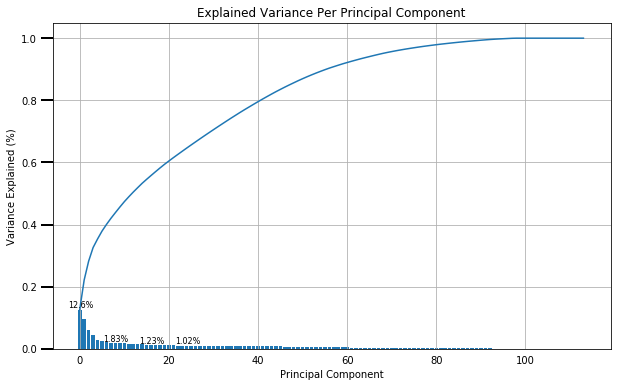

In [38]:
# Investigate the variance accounted for by each principal component.

# Call the scree_plot() function from the notebook in Lesson 4 (pasted above)
scree_plot(pca_all)
plt.grid()
print(np.cumsum(pca_all.explained_variance_ratio_)[7])
print(np.cumsum(pca_all.explained_variance_ratio_)[9])
print(np.cumsum(pca_all.explained_variance_ratio_)[19])
print(np.cumsum(pca_all.explained_variance_ratio_)[29])
print(np.cumsum(pca_all.explained_variance_ratio_)[39])
print(np.cumsum(pca_all.explained_variance_ratio_)[49])
print(pca_all.explained_variance_ratio_)
print("Note that there is a bug in the annotation code for values below 1.0e-2.")

In [39]:
# Re-apply PCA to the data while selecting for number of components to retain.

n_components = 50
pca = PCA(n_components)
X_transformed = pca.fit_transform(azdias_scaled.values)
print(X_transformed.shape)

(625850, 50)


In [40]:
# Print the total amount of data values explained by the first 50 principal components
print(np.cumsum(pca.explained_variance_ratio_)[-1])

0.862808393032


### Discussion 2.2: Perform Dimensionality Reduction

Leveraging the scree plot code from Lesson 4, I found that there are two "soft knees" in the curve of cumulative explained variance, one around eight (or so) components, and the other around 55 (or so) components. 

I chose 50 as a cutoff for components. These first 50 components account for >85% of the variance in the data.

Note to developers: I found a bug in the `scree_plot()` function of Lesson 4's `helper_functions.py`. The annotations do not monotonically decrease, even though the explained variance is expected to, and does. It's not computing the annotation text correctly for values less than 1.0e-2. To avoid misleading annotations in my results, I modified the function to cut these off and not show them on the figure.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [41]:
print(azdias_scaled.keys())

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'GEBAEUDETYP_1.0', 'GEBAEUDETYP_2.0', 'GEBAEUDETYP_3.0',
       'GEBAEUDETYP_4.0', 'GEBAEUDETYP_6.0', 'GEBAEUDETYP_8.0', 'PRAEGENDE',
       'JUGENDJAHRE', 'CAMEO_INTL_2015_Family', 'CAMEO_INTL_2015_Affluence'],
      dtype='object', length=114)


In [107]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Again, leveraging the helper_functions.py from Lesson 4
dimensions = ['Dim. {}'.format(i) for i in range(len(pca.components_))]
components = pd.DataFrame(np.round(pca.components_, 4), columns=azdias_scaled.keys())
components.index = dimensions

def print_sorted(i_dim, components):
    dim_components = components.iloc[i_dim]
    
    # https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    # https://www.w3resource.com/python-exercises/dictionary/python-data-type-dictionary-exercise-1.php
    sorted_components = {k: v for k, v in sorted(dim_components.items(), key=lambda item: item[1], reverse=True)}
    
    print("{:28}{}".format(dimensions[i_dim] + " Feature Name", " Weight"))
    print("{:28}{}".format("-"*19, " " + "-"*6))
    
    for component in sorted_components:
        #print(component)
        print("{:28}{: .4f}".format(component, sorted_components[component]))
        
print_sorted(0, components)

Dim. 0 Feature Name          Weight
-------------------          ------
LP_STATUS_GROB_1.0           0.1987
HH_EINKOMMEN_SCORE           0.1784
PLZ8_ANTG3                   0.1762
PLZ8_ANTG4                   0.1714
CAMEO_INTL_2015_Affluence    0.1672
FINANZ_SPARER                0.1634
ORTSGR_KLS9                  0.1500
EWDICHTE                     0.1474
FINANZTYP_1                  0.1403
LP_STATUS_FEIN_2.0           0.1340
FINANZ_HAUSBAUER             0.1339
SEMIO_PFLICHT                0.1271
JUGENDJAHRE                  0.1269
KBA05_ANTG4                  0.1253
SEMIO_REL                    0.1208
LP_STATUS_FEIN_1.0           0.1173
PLZ8_ANTG2                   0.1166
KBA05_ANTG3                  0.1159
SEMIO_TRADV                  0.1155
ANZ_HAUSHALTE_AKTIV          0.1126
ARBEIT                       0.1102
SEMIO_RAT                    0.1087
RELAT_AB                     0.1003
FINANZ_UNAUFFAELLIGER        0.0980
ZABEOTYP_5                   0.0976
FINANZ_ANLEGER              

In [108]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_sorted(1, components)

Dim. 1 Feature Name          Weight
-------------------          ------
ALTERSKATEGORIE_GROB         0.2154
ZABEOTYP_3                   0.1978
FINANZ_VORSORGER             0.1964
SEMIO_ERL                    0.1773
RETOURTYP_BK_S               0.1567
SEMIO_LUST                   0.1472
LP_STATUS_FEIN_1.0           0.1338
FINANZ_HAUSBAUER             0.1239
W_KEIT_KIND_HH               0.1209
PLZ8_ANTG3                   0.1181
PLZ8_ANTG4                   0.1135
ORTSGR_KLS9                  0.1091
EWDICHTE                     0.1089
CAMEO_INTL_2015_Affluence    0.0973
FINANZTYP_5                  0.0954
CJT_GESAMTTYP_2.0            0.0922
SEMIO_KRIT                   0.0873
KBA05_ANTG4                  0.0854
ARBEIT                       0.0810
PLZ8_ANTG2                   0.0785
HH_EINKOMMEN_SCORE           0.0782
ANZ_HAUSHALTE_AKTIV          0.0770
RELAT_AB                     0.0759
LP_STATUS_GROB_1.0           0.0745
SEMIO_KAEM                   0.0744
KBA05_ANTG3                 

In [109]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_sorted(2, components)

Dim. 2 Feature Name          Weight
-------------------          ------
SEMIO_VERT                   0.3287
SEMIO_FAM                    0.2634
SEMIO_SOZ                    0.2604
SEMIO_KULT                   0.2498
FINANZTYP_5                  0.1461
FINANZ_MINIMALIST            0.1328
ZABEOTYP_1                   0.1193
SEMIO_REL                    0.1178
RETOURTYP_BK_S               0.0885
SEMIO_MAT                    0.0847
GREEN_AVANTGARDE             0.0831
PRAEGENDE                    0.0831
EWDICHTE                     0.0749
ORTSGR_KLS9                  0.0737
W_KEIT_KIND_HH               0.0650
LP_STATUS_FEIN_10.0          0.0576
LP_STATUS_GROB_5.0           0.0576
PLZ8_ANTG3                   0.0554
PLZ8_ANTG4                   0.0554
ZABEOTYP_6                   0.0547
FINANZ_VORSORGER             0.0497
LP_STATUS_FEIN_3.0           0.0491
LP_STATUS_FEIN_1.0           0.0482
PLZ8_ANTG2                   0.0406
RELAT_AB                     0.0392
GEBAEUDETYP_3.0             

### Discussion 2.3: Interpret Principal Components

The first principal component has a top-3 weight cluster for features 
1. LP_STATUS_GROB_1.0 (Low-income earners social status) (0.1987)
2. HH_EINKOMMEN_SCORE (Estimated household net income (1: highest)) (0.1784)
3. PLZ8_ANTG3 (Number of 6-10 family houses in region (0: none)) (0.1762)

The first principal component has anti-correlated bottom-2 weights of:
1. MOBI_REGIO (Movement patterns (1: very high)) (-0.2023)
2. FINANZ_MINIMALIST (Low financial interest Financial typology (1: very high affinity)) -0.2156

A summary picture of this principal component is of low-income earners in large multi-family dwellings, with high movement patterns and low financial interest.

The second principal component has a top-3 weight cluster between features ALTERSKATEGORIE_GROB (Estimated age by name) (0.2154), ZABEOTYP_3 (Energy consumption typology) (0.1978), and FINANZ_VORSORGER (Financial typology for "be prepared" dimension) (0.1964). This provides some insight that these three dimensions are correlated. 

In this same second principal component, we see that the features FINANZ_UNAUFFAELLIGER (Financial typology for "inconspicuous" dimension) (-0.2027), SEMIO_REL (Personality typology for "religious" dimension) (-0.2072), and JUGENDJAHRE (Dominating decade of person's youth) (-0.2187) are most strongly anticorrelated with the ones above. While I don't really know what the first one means, it does seem intuitive to me that older people would be more religious (lowest number is highest affinity), and to have their youth in an earlier decade.

The third principal component has a top-4 weight cluster between SEMIO_VERT (0.3287), SEMIO_FAM (0.2634), SEMIO_SOZ (0.2604), and SEMIO_KULT (0.2498). These are personality typologies for "dreamful", "family-minded", "socially-minded", and "cultural-minded". 

The third principal component features anti-correlated with the top-4 are a bottom-4 weight cluster of SEMIO_KRIT (-0.2647), SEMIO_DOM (-0.2831), SEMIO_KAEM (-0.3168), and ANREDE_KZ (-0.3496). These are the personality typologies for "critical-minded", "dominant-minded", "combative attitude", and gender (male = 1, female = 2). It does make sense to me that these bottom-4 personality attributes are anti-correlated with the top-4, and it further makes sense that the bottom-4 personality traits KRIT, DOM, and KAEM are correlated with the male/female encoding, since a lower score on these traits corresponds to a higher affinity. This means that males score higher on these traits, and register as more critical-minded, dominant-minded, and combative.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [45]:
# https://stackoverflow.com/questions/40828929/sklearn-mean-distance-from-centroid-of-each-cluster

def k_mean_distance_indiv(data, cvec, i_centroid, cluster_labels):
    # Calculate Euclidean distance for each data point assigned to centroid 
    distances = [np.linalg.norm(xvec - cvec) for xvec in data[cluster_labels == i_centroid]]
    
    # return the mean value
    return np.mean(distances)

def k_mean_distance(X_data, clusters, centroids):
    
    c_mean_distances = []
    for i, cvec in enumerate(centroids):
        mean_distance = k_mean_distance_indiv(X_data, cvec, i, clusters)
        c_mean_distances.append(mean_distance)
        
    return np.mean(c_mean_distances), c_mean_distances

In [46]:
# Over a number of different cluster counts...

scores = [np.nan, np.nan]
score_derived_distances = [np.nan, np.nan]
mean_distances = [np.nan, np.nan]
mean_transformed_distances = [np.nan, np.nan]

data = X_transformed

for n_clusters in range(2, 21):

    # run k-means clustering on the data and...
    
    kmeans = KMeans(n_clusters)
    
    print("Performing fit for n_clusters = {}".format(n_clusters))
    
    clusters = kmeans.fit_predict(data)
    
    # compute the average within-cluster distances.
    
    # Method 1
    distances = kmeans.transform(data)
    
    nearest_transformed_distances = np.zeros((distances.shape[0]))
    for i in range(n_clusters):
        nearest_transformed_distances += np.multiply(distances[:, i], clusters == i)
    
    mean_transformed_distance = np.mean(nearest_transformed_distances)
    
    # Method 2
    # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    # https://stackoverflow.com/questions/40828929/sklearn-mean-distance-from-centroid-of-each-cluster
    centroids = kmeans.cluster_centers_

    print("Calculating metrics for n_clusters = {}".format(n_clusters))
    
    mean_distance, c_mean_distances = k_mean_distance(X_transformed, clusters, centroids)
    
    # Method 3
    score = kmeans.score(data)
    
    score_derived_distance = np.sqrt(-score / X_transformed.shape[0])
    
    print("For n_clusters = {}, model score = {:4f}".format(n_clusters, score))
    
    print("For n_clusters = {}, mean transformed distance = {:4f}, mean distance = {:4f}, score-derived distance = {:4f}".format(
        n_clusters, mean_transformed_distance, mean_distance, score_derived_distance))
    
    print("For n_clusters = {}, the cluster mean distances = {}".format(n_clusters, c_mean_distances))
    
    scores.append(score)
    mean_transformed_distances.append(mean_transformed_distance)
    mean_distances.append(mean_distance)
    score_derived_distances.append(score_derived_distance)

Performing fit for n_clusters = 2
Calculating metrics for n_clusters = 2
For n_clusters = 2, model score = -53320309.025738
For n_clusters = 2, mean transformed distance = 9.093385, mean distance = 9.092189, score-derived distance = 9.230202
For n_clusters = 2, the cluster mean distances = [8.8527265964971331, 9.3316516982441531]
Performing fit for n_clusters = 3
Calculating metrics for n_clusters = 3
For n_clusters = 3, model score = -49598487.552316
For n_clusters = 3, mean transformed distance = 8.749513, mean distance = 8.722263, score-derived distance = 8.902236
For n_clusters = 3, the cluster mean distances = [8.7980049295600065, 8.3294418844690075, 9.0393435732548877]
Performing fit for n_clusters = 4
Calculating metrics for n_clusters = 4
For n_clusters = 4, model score = -47462653.484413
For n_clusters = 4, mean transformed distance = 8.544877, mean distance = 8.558558, score-derived distance = 8.708450
For n_clusters = 4, the cluster mean distances = [8.6375872775235472, 8.28

[nan, nan, 9.230201895322887, 8.9022356942075493, 8.7084503276640355, 8.5417436358209891, 8.4234595749971142, 8.3252962850343231, 8.2273954641923694, 8.1289502661213131, 8.0644812569696267, 7.9955626132578628, 7.9407518283345784, 7.8844015886945904, 7.8407474253809939, 7.7775361553310116, 7.7276384983426905, 7.7176696414255099, 7.6509195853220051, 7.6339130364393091, 7.5919762331508567]


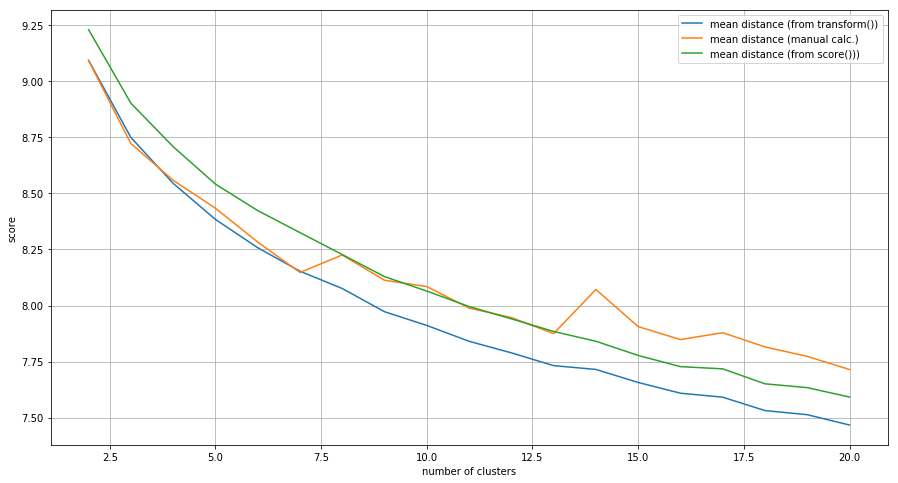

In [47]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

print(score_derived_distances)

fig = plt.figure(figsize=(15,8))
range_clusters = range(21)
plt.plot(range_clusters, mean_transformed_distances, label='mean distance (from transform())');
plt.plot(range_clusters, mean_distances, label='mean distance (manual calc.)');
plt.plot(range_clusters, score_derived_distances, label='mean distance (from score()))');
plt.legend()
plt.ylabel('score')
plt.xlabel('number of clusters')
plt.grid()

In [48]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

n_clusters_final = 15
kmeans_final = KMeans(n_clusters_final)
print("Performing fit for n_clusters_final = {}".format(n_clusters_final))
clusters_genpop = kmeans_final.fit_predict(data)
centroids_genpop = kmeans_final.cluster_centers_
score_genpop = kmeans_final.score(data)
score_derived_distance_genpop = np.sqrt(-score_genpop / data.shape[0])
print(score_derived_distance_genpop)

Performing fit for n_clusters_final = 15
7.81297500792


### Discussion 3.1: Apply Clustering to General Population

#### Distance Calculation: Method 1
The KMeans `transform()` function returns the distances to each cluster for each data point. I attempted to calculate the average distance from this return data, but in hindsight realize why on first attempt I got a metric that was too big: it was including the distance to _every_ centroid in the metric instead of the distance to just the k-means labeled centroid.

I then modified my code to include only the distance to the labeled centroid, but found that the calculated result was not identical to either of my other methods below. For the sake of time, I did not investigate this further.

#### Distance Calculation: Method 2
I also attempted to compute an "average of averages" metric on the result, since this would not be the same as the inertia returned above (https://math.stackexchange.com/questions/115091/is-the-average-of-the-averages-equal-to-the-average-of-all-the-numbers-originall). There seems to be something wrong with my implementation, because the values I calculated are not monotonically decreasing with increasing `k`.

#### Distance Calculation: Method 3
The documentation for the KMeans `score()` function is a bit opaque, stating that it returns "Opposite of the value of X on the K-means objective". Looking under the hood, it returns the negative of the inertia return value from `_labels_inertia()`. This function, in turn, plainly states the inertia as the "Sum of squared distances of samples to their closest cluster center." I therefore computed the average distance to the nearest cluster center by taking the negative, dividing by the number of samples, and taking the square root.

#### Summary
Based on a graph of the mean distance as a function of number of components, I decided to segment the population in to 15 clusters, because there seemed to be a knee in the curve around that value (with diminishing returns above this number of clusters). While this notebook is currently set up to test up to 20 clusters, I had previously run it out to 30 clusters, and decided on 15 based on this more full set of results.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [49]:
# Load in the customer demographics data.

customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [51]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Run the previously-defined function
customers_cleaned = clean_data(customers)

# Drop missing or nan data
print(customers_cleaned.shape)
customers_cleaned.dropna(axis=0, inplace=True)
print(customers_cleaned.shape)

# Apply feature scaling to the general population demographics data.
# https://stackoverflow.com/questions/35723472/how-to-use-sklearn-fit-transform-with-pandas-and-return-dataframe-instead-of-num
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customers_cleaned.values)
customers_scaled = pd.DataFrame(scaled_features, index=customers_cleaned.index, columns=customers_cleaned.columns)
print(customers_scaled.shape)

# Perform principal component analysis transform on the customer data
X_customers_pca = pca.transform(customers_scaled.values)
data = X_customers_pca

# Print the total amount of data values explained by the first 50 principal components
print(np.cumsum(pca.explained_variance_ratio_)[-1])

# Predict the clusters for the customer dataset
clusters_customers = kmeans_final.predict(data)

Of the 191652 rows, there are between 0 and 48 missing values in the 79 columns.
Dropping columns ['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Replacing values {'OST_WEST_KZ': {'O': 0, 'W': 1}}
Performing One-Hot Encoding on ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'ZABEOTYP', 'GEBAEUDETYP']
Dropping columns ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']
(135799, 114)
(115818, 114)
(115818, 114)
0.862808393032


In [52]:
# Check to see if we have all of the columns represented from the general population model
# https://www.geeksforgeeks.org/python-difference-two-lists/
customers_features = customers_scaled.count().index.tolist()
genpop_features = azdias_scaled.count().index.tolist()
print(list(set(genpop_features) - set(customers_features)))

[]


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

[ 11.11304626   7.23352241   5.4247823    6.46768395   8.45122633
   6.71822322   9.61907805   8.85739394   3.35399856   8.0322761
   2.86714069   6.27322841   6.49708397   4.45202525   4.63929056]
100.0
[ 23.09571915   7.04035642   3.29223437   8.19648069  12.95135471
   2.16546651   3.17394533   7.24067071   4.80667945   4.59859435
   4.62104336   6.96437514   8.38816073   2.97622131   0.48869778]
100.0
[ 2.07825277  0.97329572  0.60688783  1.26729765  1.53248229  0.32232726
  0.32996357  0.81747191  1.43311911  0.57251448  1.61172536  1.11017401
  1.29106547  0.66850953  0.1053389 ]
{1: 2.0782527680761165, 11: 1.6117253608820217, 5: 1.5324822934128461, 9: 1.4331191133647476, 13: 1.2910654655368856, 4: 1.2672976522655666, 12: 1.1101740102291651, 2: 0.97329572270529274, 8: 0.81747190574055661, 14: 0.66850953184659156, 3: 0.60688783218000841, 10: 0.57251447615537687, 7: 0.3299635692991752, 6: 0.32232726392631272, 15: 0.105338904219429}


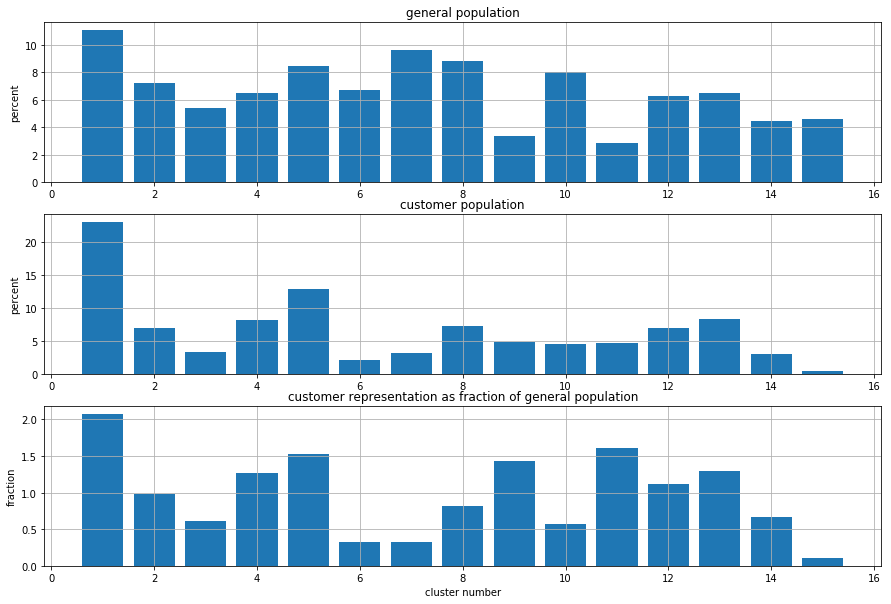

In [84]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# https://stackoverflow.com/questions/12282232/how-do-i-count-unique-values-inside-a-list
genpop_labels = list(Counter(clusters_genpop).keys()) # equals to list(set(words))
genpop_counts = list(Counter(clusters_genpop).values()) # counts the elements' frequency
genpop_percents = np.array(genpop_counts) / sum(genpop_counts) * 100.0

customers_labels = list(Counter(clusters_customers).keys())
customers_counts = list(Counter(clusters_customers).values())
customers_percents = np.array(customers_counts) / sum(customers_counts) * 100.0

# Calculate the representation of customers in each cluster compared to general population within that cluster
customers_representation = np.divide(customers_percents, genpop_percents)

print(genpop_percents)
print(sum(genpop_percents))
print(customers_percents)
print(sum(customers_percents))
print(customers_representation)

rep_dict = {}
for i in range(1, n_clusters_final + 1):
    rep_dict[i] = customers_representation[i - 1]
    
# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
# https://www.w3resource.com/python-exercises/dictionary/python-data-type-dictionary-exercise-1.php
sorted_rep = {k: v for k, v in sorted(rep_dict.items(), key=lambda item: item[1], reverse=True)}
print(sorted_rep)

fig = plt.figure(figsize=(15,10))
plt.subplot(3, 1, 1)
plt.bar(range(1, n_clusters_final + 1), genpop_percents)
plt.ylabel('percent')
plt.grid()
plt.title('general population')

plt.subplot(3, 1, 2)
plt.bar(range(1, n_clusters_final + 1), customers_percents)
plt.ylabel('percent')
plt.grid()
plt.title('customer population')

plt.subplot(3, 1, 3)
plt.bar(range(1, n_clusters_final + 1), customers_representation)
plt.xlabel('cluster number')
plt.ylabel('fraction')
plt.grid()
plt.title('customer representation as fraction of general population');

In [110]:
# https://stackoverflow.com/questions/33888062/what-are-the-centroid-of-k-means-clusters-with-pca-decomposition
  
centers = pca.inverse_transform(centroids_genpop)
print(centers.shape)
print(len(centers))
print(centroids_genpop.shape)
print(type(centroids_genpop))
print(pca.components_.shape)

(15, 114)
15
(15, 50)
<class 'numpy.ndarray'>
(50, 114)


In [111]:
# Again, leveraging the helper_functions.py from Lesson 4
dimensions = ['Cluster {}'.format(i) for i in range(len(centers))]
components = pd.DataFrame(np.round(centers, 4), columns=customers_scaled.keys())
components.index = dimensions

print_sorted(0, components)

Cluster 0 Feature Name       Weight
-------------------          ------
FINANZTYP_3                  4.3934
FINANZ_UNAUFFAELLIGER        1.3496
JUGENDJAHRE                  1.0593
LP_STATUS_GROB_4.0           0.9577
KBA05_ANTG1                  0.9243
LP_STATUS_FEIN_10.0          0.8950
LP_STATUS_GROB_5.0           0.8950
MOBI_REGIO                   0.8782
ZABEOTYP_1                   0.7652
FINANZ_MINIMALIST            0.7640
LP_STATUS_FEIN_9.0           0.7584
FINANZ_SPARER                0.7513
KBA05_GBZ                    0.7258
PLZ8_ANTG1                   0.7192
GREEN_AVANTGARDE             0.6878
PRAEGENDE                    0.6878
ONLINE_AFFINITAET            0.6768
LP_STATUS_FEIN_8.0           0.6705
SEMIO_REL                    0.6550
SEMIO_KULT                   0.6526
SEMIO_SOZ                    0.5986
SEMIO_PFLICHT                0.5884
GFK_URLAUBERTYP_2.0          0.5725
FINANZ_ANLEGER               0.5554
ZABEOTYP_2                   0.5368
GEBAEUDETYP_1.0             

In [72]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

### Response

The first cluster ("Cluster 0") has more than 2x representation compared to the general population. It has a top-3 weights of:
1. FINANZTYP_3 (Home ownership financial type) (4.3934)
2. FINANZ_UNAUFFAELLIGER (Inconspicuous financial typology (1: very high)) (1.3496) => NOT inconspicuous
3. JUGENDJAHRE (Dominant decade of youth) (1.0593) => the younger set

It has a bottom-3 weights for:
1. HH_EINKOMMEN_SCORE (Estimated household net income (1: highest)) (-0.9699)
2. FINANZ_VORSORGER ("Be prepared" financial typology affinity (1: very high)) (-1.2966)
3. FINANZ_HAUSBAUER (Home ownership financial typology affinity (1: very high)) (-1.8142)

In summary, this cluster seems to consist of individuals that are typically younger homeowners with high household net income. They also tend to exhibit high "be prepared" and not inconspicuous financial typology.

In [112]:
print_sorted(14, components)

Cluster 14 Feature Name      Weight
-------------------          ------
SEMIO_FAM                    1.4056
SEMIO_KULT                   1.3876
FINANZ_SPARER                1.2694
SEMIO_REL                    1.2636
SEMIO_SOZ                    1.1866
JUGENDJAHRE                  1.0561
FINANZ_UNAUFFAELLIGER        1.0069
ZABEOTYP_5                   0.9513
SEMIO_VERT                   0.9502
FINANZTYP_1                  0.9369
LP_STATUS_GROB_1.0           0.8991
LP_STATUS_FEIN_2.0           0.8619
SEMIO_PFLICHT                0.8226
HH_EINKOMMEN_SCORE           0.6608
SEMIO_TRADV                  0.6474
PLZ8_ANTG3                   0.6310
SEMIO_MAT                    0.6294
CAMEO_INTL_2015_Affluence    0.6224
FINANZ_ANLEGER               0.5944
PLZ8_ANTG4                   0.5886
ORTSGR_KLS9                  0.5270
KBA05_ANTG3                  0.5205
EWDICHTE                     0.5054
CJT_GESAMTTYP_4.0            0.4513
FINANZTYP_4                  0.4454
PLZ8_ANTG2                  

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

### Response

The 15th cluster ("Dim. 15") is hardly represented at all in the customer set (<11% of what would be expected if our customer set represented the general population in terms of cluster distribution). This cluster has a top-4 weights of:
1. SEMIO_FAM (Family-minded Personality typology (1: highest affinity)) (1.4056) => NOT family-minded
2. SEMIO_KULT (Cultural-minded Personality typology (1: highest affinity)) (1.3876) => NOT cultural-minded
3. FINANZ_SPARER (Money-saver Financial typology (1: very high)) (1.2694) => NOT a money-saver
4. SEMIO_REL (religious Personality typology (1: highest affinity)) (1.2636) => NOT religious

It has the following bottom-3 anti-correlated weights:
1. FINANZ_VORSORGER (Be prepared Financial typology (1: very high)) (-1.0979) => "Be prepared" financial type
2. ANREDE_KZ (Gender (male = 1, female = 2)) (-1.1309) => male
3. SEMIO_ERL (Event-oriented Personality typology (1: highest affinity)) (-1.3599) => Event-oriented personality

The summary picture of the underrepresented type in this cluster is the non-religious, non-family-minded, and non-religious, event-oriented male. The FINANZ_SPARER and FINANZ_VORSORGER weights seem to be at odds with each other, as they paint a mixed picture of financial type.

### Discussion 3.3: Compare Customer Data to Demographics Data

The mail-order company tends to have attracted customers that are younger homeowners with high household net income. More details are above as desired.

The mail-order company tends _not_ to attract customers that are non-religious, non-family-minded, and non-religious, event-oriented males. These individuals tend not to be money-savers, but also exhibit some "be prepared" financial trait affinity.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.